In [1]:
datapath = "./dataset/" #path to the dataset folder

In [2]:
import pandas as pd
import regex
from polyglot.text import Text, Word
from tqdm import tqdm
from langcodes import *
import seaborn as sns

In [3]:
multisocial = pd.read_csv(datapath + f'multisocial_v1.csv.gz', lineterminator='\n')

In [4]:
multisocial.head()

,index,text,label,length,source,language,domain,topic,split,multi_label,filter
0,0,"Hola, ¿qué tal? - ¿Qué tal?",1,6,multisocial_discord,es,social_media,unknown,train,aya-101,False
1,1,The breathtaking picture shared by @sashagrey ...,1,10,multisocial_twitter,en,social_media,unknown,train,v5-Eagle-7B-HF,False
2,2,Πρέπει να πέσετε στην σ,1,5,multisocial_telegram,el,social_media,unknown,train,opt-iml-max-30b,False
3,3,"Дійсно, християнство передбачає дотримання пев...",1,53,multisocial_telegram,uk,social_media,unknown,train,gemini,False
4,4,I Your patience is still being put to the test...,1,25,multisocial_telegram,cs,social_media,unknown,train,Mistral-7B-Instruct-v0.2,False


In [5]:
multisocial.domain.value_counts()

social_media    472097
Name: domain, dtype: int64

In [6]:
multisocial[multisocial.text.duplicated(keep=False)]

,index,text,label,length,source,language,domain,topic,split,multi_label,filter


In [7]:
data = multisocial.reset_index()

In [8]:
#check for noise
phrases = ['assist', 'asist', 'task', 'instruc', 'output', 'language model', 'ai model', 'as an ai'] #maybe in other languages should be filtered as well
for phrase in phrases:
  print(f'{phrase}\n{data[data.text.str.lower().str.contains(phrase)][["label", "domain"]].value_counts()}\n')

assist
label  domain      
1      social_media    4552
0      social_media      85
dtype: int64

asist
label  domain      
1      social_media    1675
0      social_media      20
dtype: int64

task
label  domain      
1      social_media    615
0      social_media     23
dtype: int64

instruc
label  domain      
1      social_media    350
0      social_media      8
dtype: int64

output
label  domain      
1      social_media    260
0      social_media      1
dtype: int64

language model
label  domain      
1      social_media    150
dtype: int64

ai model
label  domain      
1      social_media    11
dtype: int64

as an ai
label  domain      
1      social_media    95
dtype: int64



In [9]:
print(f'All filtered phrases:\n{data[data.text.str.contains("|".join(phrases), na=False, case=False)].label.value_counts()}\n')

All filtered phrases:
1    7360
0     137
Name: label, dtype: int64



In [10]:
data['filter'] = False
data.loc[data.text.str.contains("|".join(phrases), na=False, case=False), 'filter'] = True

In [11]:
data.to_csv(datapath + 'multisocial_v1.csv.gz', index=False)

In [12]:
filtered = data[~data['filter']].sample(frac=1., random_state = 0).reset_index(drop=True)

In [13]:
filtered.to_csv(datapath + 'multisocial_clean.csv.gz', index=False)

In [14]:
filtered.label.value_counts()

1    406747
0     57853
Name: label, dtype: int64

In [15]:
filtered.multi_label.value_counts()

Mistral-7B-Instruct-v0.2    60363
vicuna-13b                  59810
gemini                      58792
v5-Eagle-7B-HF              58734
human                       57853
gpt-3.5-turbo-0125          57825
aya-101                     56944
opt-iml-max-30b             54279
Name: multi_label, dtype: int64

In [16]:
filtered.duplicated(subset=['text'], keep=False).value_counts()

False    464600
dtype: int64

In [17]:
filtered.language.value_counts()

es    49840
en    48260
pt    43915
nl    40029
de    30535
ru    24034
ro    23950
pl    23658
ar    23519
ca    21107
hr    20468
hu    20449
bg    20346
et    19749
cs    17114
zh    11381
uk    10372
el     7449
ga     3122
sl     3058
sk     2026
gd      219
Name: language, dtype: int64

In [18]:
filtered.groupby(['multi_label'])['language'].value_counts()

multi_label               language
Mistral-7B-Instruct-v0.2  es          6357
                          en          6295
                          pt          5661
                          nl          5178
                          de          3914
                                      ... 
vicuna-13b                el           968
                          ga           457
                          sl           389
                          sk           260
                          gd            32
Name: language, Length: 176, dtype: int64

In [19]:
filtered.split.value_counts()

train    325773
test     138827
Name: split, dtype: int64

In [20]:
filtered.groupby(['split'])['language'].value_counts()

split  language
test   es          11495
       pt          11364
       en          11116
       nl           9504
       de           9497
       ro           9161
       ru           7997
       ar           7971
       ca           7328
       pl           6971
       cs           6073
       hr           5993
       hu           5957
       et           5389
       bg           4889
       el           3643
       zh           3471
       ga           3122
       sl           3058
       uk           2583
       sk           2026
       gd            219
train  es          38345
       en          37144
       pt          32551
       nl          30525
       de          21038
       pl          16687
       ru          16037
       ar          15548
       bg          15457
       ro          14789
       hu          14492
       hr          14475
       et          14360
       ca          13779
       cs          11041
       zh           7910
       uk           7789
       el

In [21]:
print(filtered[filtered.multi_label.str.contains('human')].length.describe())
print(filtered[~filtered.multi_label.str.contains('human')].length.describe())

count    57853.000000
mean        13.433806
std         19.404261
min          3.000000
25%          4.000000
50%          7.000000
75%         15.000000
max        200.000000
Name: length, dtype: float64
count    406747.000000
mean         25.024273
std          31.792782
min           3.000000
25%           8.000000
50%          14.000000
75%          27.000000
max         200.000000
Name: length, dtype: float64


In [22]:
filtered[(filtered.split=='train') & (filtered.domain=='social_media')].groupby(['source']).language.value_counts()

source    language
discord   es          924
          en          923
          ca          855
          hr          850
          pt          818
                     ... 
twitter   ru           46
          ro            8
whatsapp  es          999
          en          972
          pt          552
Name: language, Length: 100, dtype: int64

In [23]:
temp_train = filtered[filtered.split=='train'].groupby('multi_label')['text'].count().reset_index()
temp_test = filtered[filtered.split=='test'].groupby('multi_label')['text'].count().reset_index()
temp = temp_train.merge(temp_test, how='outer', on=['multi_label']).sort_values(by=['multi_label'])
temp = temp.rename(columns={'multi_label':'Generator', 'text_x':'Train', 'text_y':'Test'})
human = temp[temp.Generator.str.contains('human')]
machine = temp[~temp.Generator.str.contains('human')]
#temp = pd.concat([human, machine], ignore_index=True)
temp = machine
total = temp.sum()
total['Generator'] = '\textbf{machine}'
temp = temp.append(total,ignore_index=True)
human['Generator'] = '\textbf{human}'
temp = temp.append(human,ignore_index=True)
temp
#with open('table.tex', 'wt') as out: temp.to_latex(buf=out, index=False, na_rep=0, escape=False, formatters={"text": str.lower}, float_format="{:.0f}".format)
print(temp.to_latex(index=False, na_rep=0, escape=False, formatters={"text": str.lower}, float_format="{:.0f}".format))

\begin{tabular}{lrr}
\toprule
               Generator &  Train &   Test \\
\midrule
Mistral-7B-Instruct-v0.2 &  42267 &  18096 \\
                 aya-101 &  39892 &  17052 \\
                  gemini &  41643 &  17149 \\
      gpt-3.5-turbo-0125 &  40451 &  17374 \\
         opt-iml-max-30b &  38037 &  16242 \\
          v5-Eagle-7B-HF &  41116 &  17618 \\
              vicuna-13b &  41881 &  17929 \\
        \textbf{machine} & 285287 & 121460 \\
          \textbf{human} &  40486 &  17367 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_95/533955512.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(total,ignore_index=True)
/tmp/ipykernel_95/533955512.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp = temp.append(human,ignore_index=True)
/tmp/ipykernel_95/533955512.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(temp.to_latex(index=False, na_rep=0, escape=False, formatters={"text": str.lower}, float_format="{:.0f}".format))


In [24]:
filtered[filtered.split=='train'].groupby('language')['text'].count()

language
ar    15548
bg    15457
ca    13779
cs    11041
de    21038
el     3806
en    37144
es    38345
et    14360
hr    14475
hu    14492
nl    30525
pl    16687
pt    32551
ro    14789
ru    16037
uk     7789
zh     7910
Name: text, dtype: int64

<AxesSubplot: xlabel='length', ylabel='Density'>

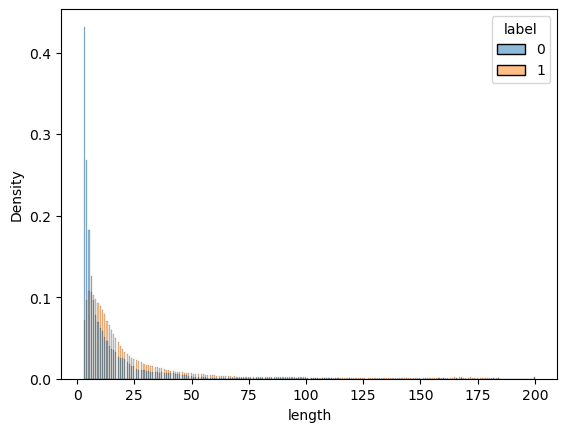

In [25]:
sns.histplot(filtered[filtered.domain=='social_media'], x="length", hue="label", stat="density", common_norm=False)

In [26]:
temp = filtered[(filtered.domain=='social_media') & (filtered.split=='train') & (filtered.multi_label=='human')].copy()
temp['source'] = [x.replace('multisocial_', '') for x in temp['source']]
temp = pd.DataFrame(temp[temp.domain=='social_media'].groupby(['source'])['language'].value_counts()).rename(columns={'language':'counts'}).reset_index()
temp.pivot('language','source').fillna(0).astype(int).style.apply(lambda x: ["background: yellow" if v >= 900 else "background: orange" if v >= 200 else "" for v in x], axis = 1)

/tmp/ipykernel_95/1795085249.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  temp.pivot('language','source').fillna(0).astype(int).style.apply(lambda x: ["background: yellow" if v >= 900 else "background: orange" if v >= 200 else "" for v in x], axis = 1)


In [27]:
temp = filtered[(filtered.domain=='social_media') & (filtered.split=='test') & (filtered.multi_label=='human')].copy()
temp['source'] = [x.replace('multisocial_', '') for x in temp['source']]
temp = pd.DataFrame(temp[temp.domain=='social_media'].groupby(['source'])['language'].value_counts()).rename(columns={'language':'counts'}).reset_index()
temp.pivot('language','source').fillna(0).astype(int).style.apply(lambda x: ["background: yellow" if v >= 900 else "background: orange" if v >= 200 else "" for v in x], axis = 1)

/tmp/ipykernel_95/3271369415.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  temp.pivot('language','source').fillna(0).astype(int).style.apply(lambda x: ["background: yellow" if v >= 900 else "background: orange" if v >= 200 else "" for v in x], axis = 1)
